# Imports

In [51]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Fonctions utiles

In [52]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Construction du jeu d'apprentissage

## Chargement des données

Charger les données d'apprentissage du Titanic à l'aide de la fonction pandas read_csv

In [53]:
train_df = pd.read_csv("data/titanic/train.csv", dtype={"Age": np.float64}, )

In [54]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Nettoyage des données

### Supprimer les colonnes inutiles du jeu de données


In [55]:
train_df = train_df.drop(['PassengerId','Name','Ticket', "Cabin"], axis=1)

### Remplacer ou supprimer les valeurs manquantes 

In [56]:
#train_df = train_df[["Age", "Fare", "Survived"]].dropna()

In [57]:
train_df["Age"].fillna(train_df["Age"].median(), inplace=True)
train_df["Fare"].fillna(train_df["Fare"].median(), inplace=True)
train_df["Embarked"].fillna("S", inplace=True)


### Transformer les variables catégorielles en variables numériques par binarisation

#### Embarked

In [58]:
embark_dummies_titanic = pd.get_dummies(train_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

In [59]:
train_df = train_df.join(embark_dummies_titanic)
train_df.drop(['Embarked'], axis=1,inplace=True)

#### Sex

Creer une nouvelle variable 'gender' à partir de la fonction get_gender() et la binariser

In [60]:
def get_gender(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

In [61]:
train_df['gender'] = train_df[['Age','Sex']].apply(get_gender,axis=1)

In [62]:
train_df['gender'].unique()

array(['male', 'female', 'child'], dtype=object)

In [63]:
gender_dummies_titanic = pd.get_dummies(train_df['gender'])
gender_dummies_titanic.drop('male', axis=1, inplace=True)
train_df = train_df.join(gender_dummies_titanic)
train_df.drop(['gender', 'Sex'], axis=1,inplace=True)

#### Pclass

In [64]:
pclass_dummies_titanic  = pd.get_dummies(train_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

train_df = train_df.join(pclass_dummies_titanic)
train_df.drop(['Pclass'], axis=1,inplace=True)

### Creation de nouvelles variables
#### Family

Creer une nouvelle variable boolean family pour les voyageurs étant en famille sur le bateau

In [65]:
train_df['Family'] =  train_df["Parch"] + train_df["SibSp"]
train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0

/home/ngarnier/.local/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Verifier que toutes les variables sont de type numérique

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived    891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
C           891 non-null uint8
Q           891 non-null uint8
child       891 non-null uint8
female      891 non-null uint8
Class_1     891 non-null uint8
Class_2     891 non-null uint8
Family      891 non-null int64
dtypes: float64(2), int64(4), uint8(6)
memory usage: 47.1 KB


# Apprentissage

## Preparation des jeux de données

* Créer un jeu d'apprentissage (70%) et un jeu de validation (3O%)
* Séparer la cible du reste des données

Variables à créer: X_train, Y_train, X_test, Y_test

In [81]:
from sklearn.cross_validation import train_test_split

Y = train_df["Survived"]
X = train_df.drop("Survived",axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=42)

## Choix du modèle 

Choisir un modèle de SKlearn, l'entrainer sur le jeu d'apprentissage

In [82]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

GaussianNB(priors=None)

## Prédire la survie

Prédire la survie sur le jeu d'apprentissage puis sur le jeu de test

In [83]:
preds = gaussian.predict(X_test)


## Evaluation du modèle

* Utiliser différente métriques de sklearn.metrics pour évaluer les performances du modèle
* Afficher la matrice de confusion grace à la fonction plot_confusion_matrix

In [84]:
# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
cm = confusion_matrix(Y_test, preds)
print(cm)
print("Precision {}".format(precision_score(Y_test, preds)))
print("Recall {}".format(recall_score(Y_test, preds)))

[[129  28]
 [ 27  84]]
Precision 0.75
Recall 0.7567567567567568


Confusion matrix, without normalization
[[129  28]
 [ 27  84]]


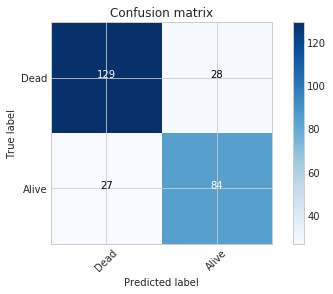

In [85]:
plot_confusion_matrix(cm, ["Dead", "Alive"])

In [86]:
from sklearn import metrics
print(metrics.classification_report(Y_test, gaussian.predict(X_test)))

             precision    recall  f1-score   support

          0       0.83      0.82      0.82       157
          1       0.75      0.76      0.75       111

avg / total       0.80      0.79      0.79       268



# Optimisation

In [87]:
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft')

In [88]:
eclf.fit(X_train, Y_train)
preds = eclf.predict(X_test)

In [89]:
print(metrics.classification_report(Y_test, preds))

             precision    recall  f1-score   support

          0       0.76      0.89      0.82       157
          1       0.79      0.60      0.68       111

avg / total       0.77      0.77      0.76       268



# Cross-validation

In [90]:
from sklearn.model_selection import GridSearchCV

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 5.0, 20, 50, 100.0], 'rf__n_estimators': [20,100, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(X_train, Y_train)

In [91]:
grid.best_params_, grid.best_score_

({'lr__C': 5.0, 'rf__n_estimators': 20}, 0.8218298555377207)

In [92]:
preds = grid.best_estimator_.predict(X_test)
print(metrics.classification_report(Y_test, preds))

             precision    recall  f1-score   support

          0       0.81      0.83      0.82       157
          1       0.75      0.73      0.74       111

avg / total       0.79      0.79      0.79       268



# ROC curve

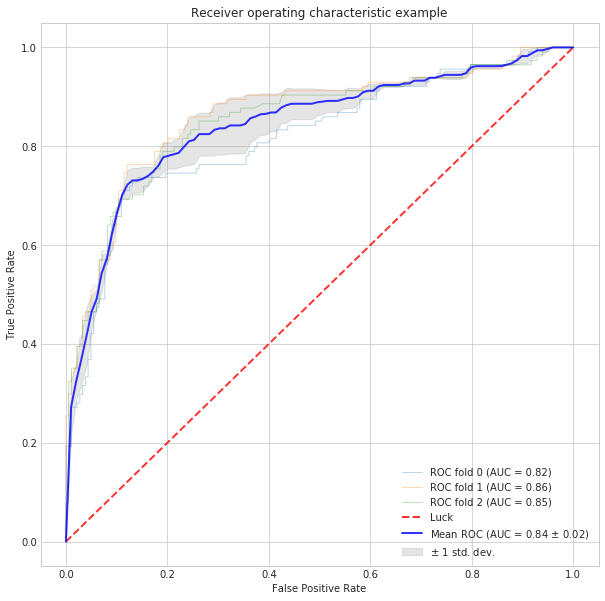

In [106]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

# Classification and ROC analysis
random_state = 42
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3)
classifier = SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, Y):
    clf = classifier.fit(X.loc[train], Y.loc[train])
    probas_ =  clf.predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
pd.Series().